In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof

In [2]:
full_shmoof_df = pd.read_csv("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", index_col=0).reset_index(drop=True)

train_df = full_shmoof_df.sample(frac=0.8)
val_df = full_shmoof_df.drop(train_df.index)

In [3]:
kmer_length = 5
max_length = 500

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 67458 training examples and 16864 validation examples


In [4]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = shmoof.SHMoofModel(train_dataset)
    burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=3)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)

Training with regularization coefficient 0
Epoch [1/3]	 Loss: 0.03665174	 Val Loss: 0.03635204
Epoch [2/3]	 Loss: 0.03648413	 Val Loss: 0.03636247
Epoch [3/3]	 Loss: 0.03649701	 Val Loss: 0.03642580
Training with regularization coefficient 1e-08
Epoch [1/3]	 Loss: 0.03647215	 Val Loss: 0.03614391
Epoch [2/3]	 Loss: 0.03627013	 Val Loss: 0.03612335
Epoch [3/3]	 Loss: 0.03625612	 Val Loss: 0.03611110
Training with regularization coefficient 1e-07
Epoch [1/3]	 Loss: 0.03627839	 Val Loss: 0.03594610
Epoch [2/3]	 Loss: 0.03607122	 Val Loss: 0.03592207
Epoch [3/3]	 Loss: 0.03605723	 Val Loss: 0.03591167
Training with regularization coefficient 1e-06
Epoch [1/3]	 Loss: 0.03604088	 Val Loss: 0.03578049
Epoch [2/3]	 Loss: 0.03591700	 Val Loss: 0.03578018
Epoch [3/3]	 Loss: 0.03591694	 Val Loss: 0.03578017
Training with regularization coefficient 1e-05
Epoch [1/3]	 Loss: 0.03604377	 Val Loss: 0.03584173
Epoch [2/3]	 Loss: 0.03598038	 Val Loss: 0.03584173
Epoch [3/3]	 Loss: 0.03598038	 Val Loss: 

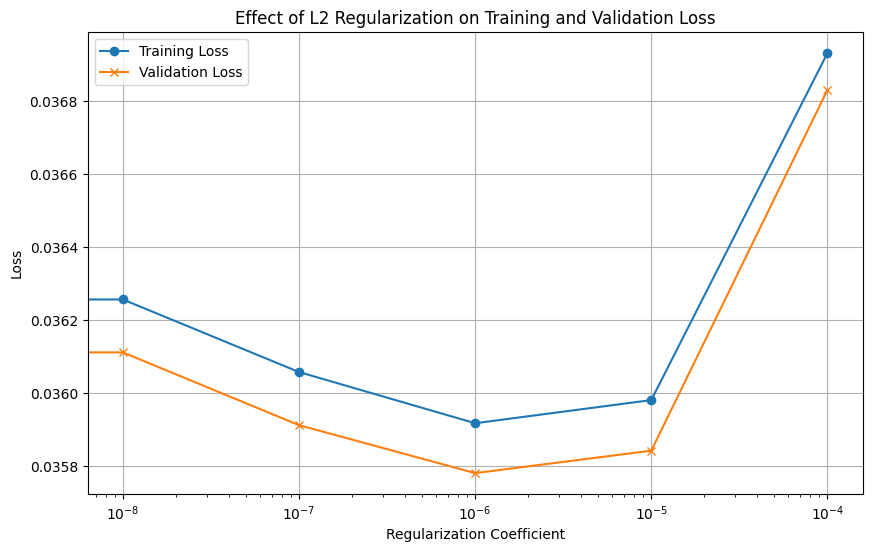

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=3)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/3]	 Loss: 0.03604079	 Val Loss: 0.03578048
Epoch [2/3]	 Loss: 0.03591700	 Val Loss: 0.03578018
Epoch [3/3]	 Loss: 0.03591694	 Val Loss: 0.03578017


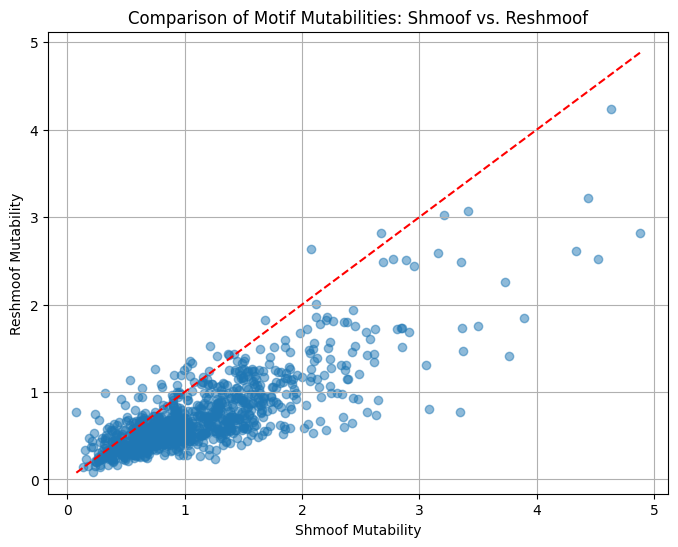

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

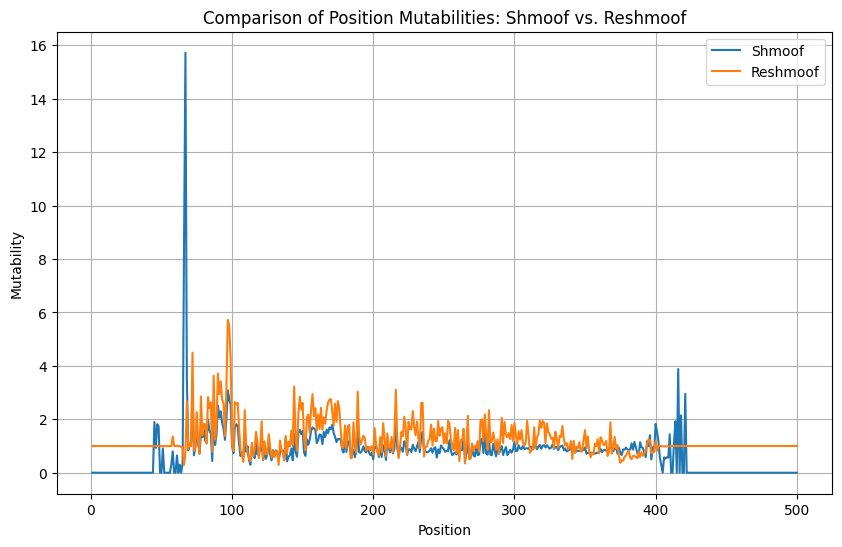

In [9]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()
